In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [28]:
df = pd.read_csv("dataset_clear.csv")

In [29]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [30]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges"],axis=1)
y = df[target]



In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8)

In [32]:
dummy = DummyRegressor()

In [33]:
numerical_features = [
       'age','bmi'
       ]
categorical_features = [
       'sex' , 'smoker', 'region','children'
       ]



In [34]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    ("pol",PolynomialFeatures(),numerical_features),
    ("one_hot_encoder",OneHotEncoder(),categorical_features)
])



In [35]:
X_train.head()

,age,sex,bmi,children,smoker,region
1113,23,male,24.510,0,no,northeast
967,21,male,25.745,2,no,northeast
598,52,female,37.525,2,no,northwest
170,63,male,41.470,0,no,southeast
275,47,female,26.600,2,no,northeast


In [36]:
dummy.fit(X_train,y_train)
dummy.score(X_test,y_test)





-0.008391982350864469

In [37]:
modelLasso= make_pipeline(my_col_trans, Lasso(alpha=100,random_state=0))
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)


0.736079328126525

In [38]:
modelLasso.score(X_test,y_test)

0.7948122088844145

/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "/home/apprenant/miniconda3/envs/envdata/

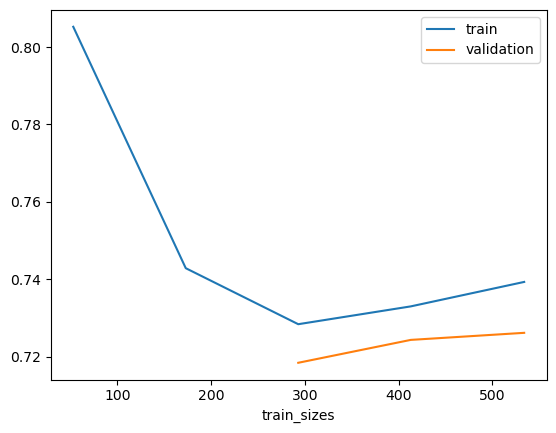

In [39]:
train_sizes, train_scores, test_scores= learning_curve(modelLasso,X_train,y_train,cv=2)
                                           
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [40]:
y_pred = modelLasso.predict(X_train)

In [41]:
residual = (y_pred - y_train).abs().sort_values()

In [42]:
residual.describe()

count     1069.000000
mean      4251.689390
std       4251.430002
min          8.902765
25%       1370.043229
50%       2799.002556
75%       6853.085375
max      31485.276801
Name: charges, dtype: float64

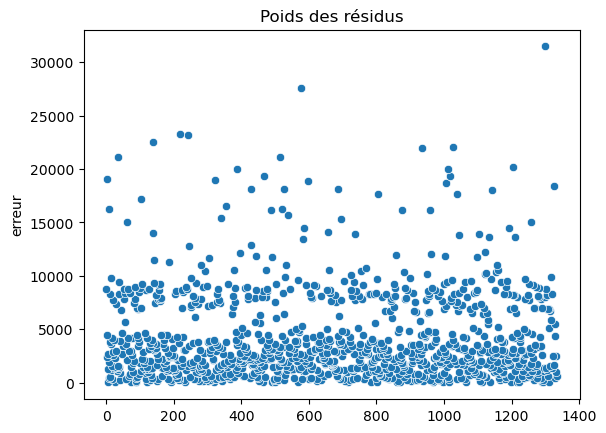

In [43]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [44]:


residual.quantile(0.98)



18091.156724640467

In [45]:
to_drop = residual[residual > residual.quantile(0.98)].index

In [46]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [47]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



0.7897253928324393

In [48]:


modelLasso.score(X_test,y_test)



0.7946863455850562

In [49]:
y_pred = modelLasso.predict(X_train)

In [50]:
residual = (y_pred - y_train).abs().sort_values()

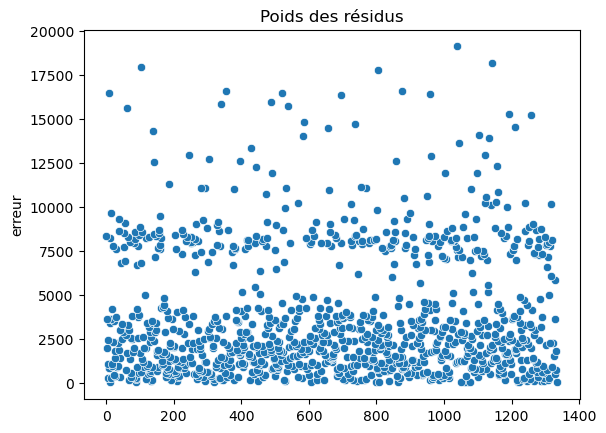

In [51]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "/home/apprenant/miniconda3/envs/envdata/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "/home/apprenant/miniconda3/envs/envdata/

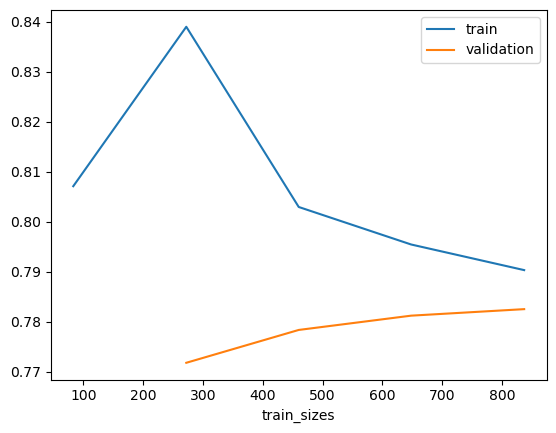

In [52]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(modelLasso,X_train,y_train,cv=5,return_times=True)
                                           
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()